# Veryifying HydroShoot impulse experiments

The goal of this notebook is to verify that the experiment ran succesfully and that the reservoir experienced the impulse and changed trajectory.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
sys.path.insert(1, os.path.join(sys.path[0], '../../'))  # for importing local packages from src

### Loading the dataset

In [2]:
DATASET_PATH = '../datasets/hydroshoot_impulse.csv'

In [3]:
from src.model.rc_dataset import ExperimentDataset

dataset = ExperimentDataset(csv_path=DATASET_PATH)
print(dataset)

Dataset properties:
	n_runs:      33
	n_steps:    240
	state_size: 360

Available targets: 
	input_Tac, input_u, input_hs, input_Rg, output_Rg, output_An, output_E, output_Tleaf

Available state variables: 
	state_E, state_psi_head, state_An, state_Eabs, state_FluxC, state_Ci, state_u, state_Tlc, state_Flux, state_gs, state_gb, state_Ei, state_par_photo.dHd



In [4]:
dataset.get_run_ids()[:12]

array(['2012-06-08__width0__0', '2012-06-08__width1__0',
       '2012-06-08__width1__1500', '2012-06-08__width2__0',
       '2012-06-08__width2__1500', '2012-06-08__width3__0',
       '2012-06-08__width3__1500', '2012-06-08__width4__0',
       '2012-06-08__width4__1500', '2012-06-08__width5__0',
       '2012-06-08__width5__1500', '2012-07-09__width0__0'], dtype=object)

## Verifying experiment inputs

In [5]:
run_ids = dataset.get_run_ids()
run_params = [run_id.split('__') for run_id in run_ids]
run_params = [(date, int(width[-1]), int(value))for (date, width, value) in run_params]


def get_run_id(date, width, value):
  return f'{date}__{width}__{value}'

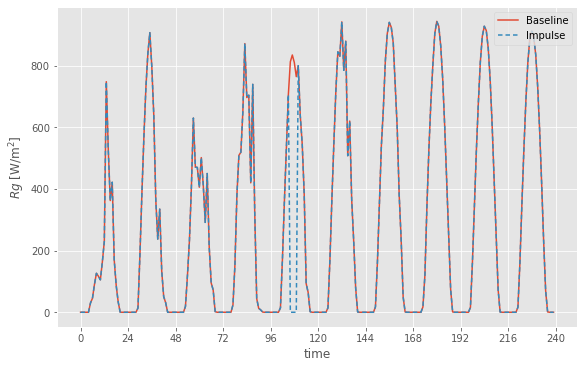

In [6]:
baseline_in = dataset.get_target('input_Rg', '2012-06-08__width0__0')
experiment_in = dataset.get_target('input_Rg', '2012-06-08__width4__0')

with plt.style.context('ggplot'):
  fig, ax = plt.subplots(1, 1, figsize=(8, 5), constrained_layout=True)
  baseline_in.plot(ax=ax, label="Baseline")
  experiment_in.plot(ax=ax, dashes=(3, 2), label="Impulse")
  ax.set_xticks(np.arange(0, len(baseline_in) + 1, 24))
  ax.set_xticklabels(np.arange(0, len(baseline_in) + 1, 24))
  ax.set_ylabel('$Rg$ [W/m$^2$]')
  ax.legend(loc='upper right')

## Verifying reservoir trajectory deviation

In [7]:
sys.path.insert(1, os.path.join(sys.path[0], '../'))

from model_config_hydroshoot import state_symbols, state_names, state_units, best_reservoirs, input_symbols, input_units

In [8]:
from sklearn.metrics import mean_squared_error


def nmse_distance(baseline, impulse):
  dist = np.empty(len(baseline))
  norm_factor = (baseline.var() + 1e-12)
  for i_step in range(len(baseline)):
    base_state = baseline[i_step]
    state = impulse[i_step]
    dist[i_step] = mean_squared_error(base_state, state) / norm_factor
  return dist

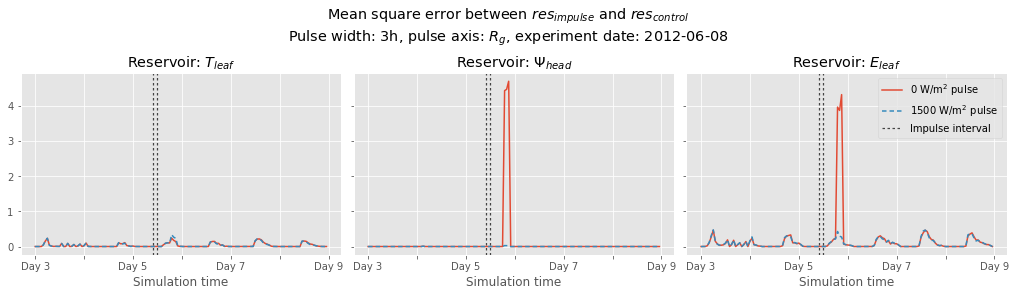

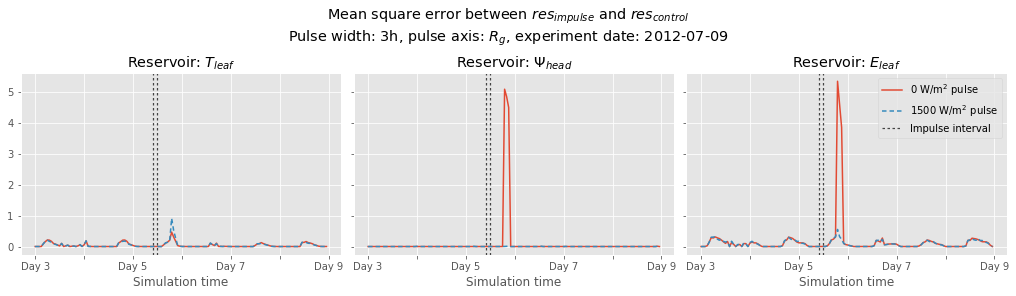

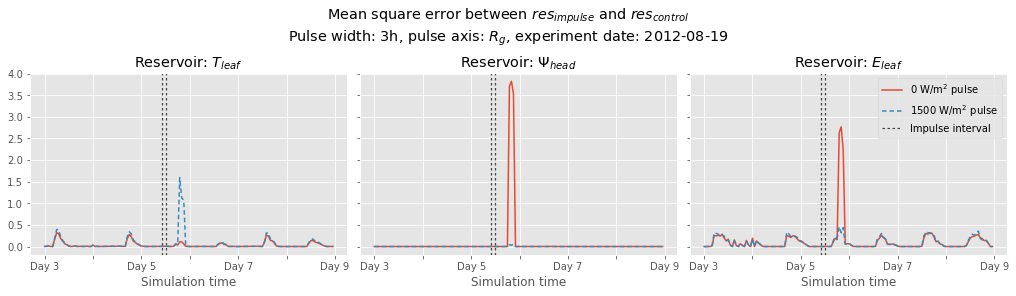

In [13]:
from sklearn.preprocessing import StandardScaler

BASELINE = '2012-06-08__width0__0'
EXPERIMENT = '2012-06-08__width3__0'
STATES = best_reservoirs


START = 24 * 2
STOP = 24 * 8

PULSE_WIDTH = 3
PULSE_VALUES = 0, 1500

plot_exps = [
  ('2012-06-08__width0__0', f'2012-06-08__width{PULSE_WIDTH}__'),
  ('2012-07-09__width0__0', f'2012-07-09__width{PULSE_WIDTH}__'),
  ('2012-08-19__width0__0', f'2012-08-19__width{PULSE_WIDTH}__'),
]

for baseline, experiment in plot_exps:

  with plt.style.context('ggplot'):
    fig, axs = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True, sharey=True)

    for state, ax in zip(STATES, axs.flatten()):
      # process data
      baseline_state = dataset.get_state(state, baseline)[START:STOP]
      experiment_state_0 = dataset.get_state(state, experiment + '0')[START:STOP]
      experiment_state_1500 = dataset.get_state(state, experiment + '1500')[START:STOP]

      distance_0 = nmse_distance(baseline_state, experiment_state_0)
      distance_1500 = nmse_distance(baseline_state, experiment_state_1500)
      
      # plot data
      ax.plot(distance_0, label='0 W/m$^2$ pulse')
      ax.plot(distance_1500, dashes=(3,2), label='1500 W/m$^2$ pulse')
      ax.set_xticks(np.arange(0, STOP - START + 1, 24))
      ax.set_xticklabels([f'Day {int(t / 24 + 1)}' if t % 48 == 0 else '' for t in np.arange(START, STOP + 1, 24)])
      ax.axvline(4 * 24 - START + 11 + (PULSE_WIDTH // 2), color='black', dashes=(2,2), alpha=0.7, linewidth=1.25, label='Impulse interval')
      ax.axvline(4 * 24 - START + 11 - (PULSE_WIDTH // 2), color='black', dashes=(2,2), alpha=0.7, linewidth=1.25)
      ax.set_xlabel('Simulation time')
      ax.set_title(f'Reservoir: {state_symbols[state]}')

      if ax is axs.flatten()[-1]:
        ax.legend(loc='upper right')
        # ax.text(4 * 24 + 11 - 5, 1, 'Impulse', rotation='vertical', transform='')

    fig.suptitle(f'Mean square error between $res_{{impulse}}$ and $res_{{control}}$'
                 f'\nPulse width: {PULSE_WIDTH}h, pulse axis: {input_symbols["input_Rg"]}, experiment date: {baseline[:10]}',
                 fontsize='x-large')



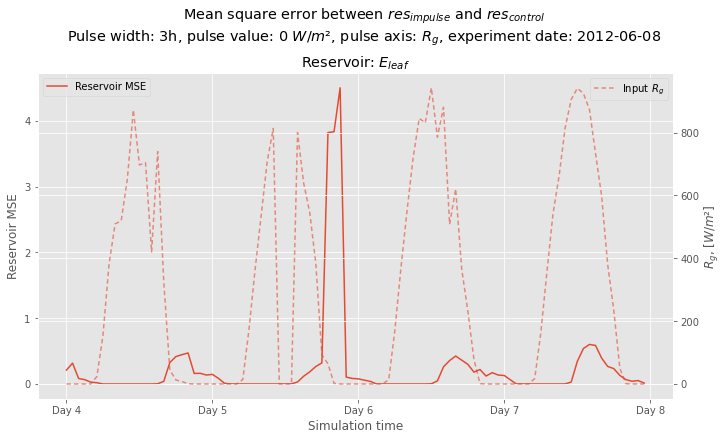

In [10]:
from sklearn.preprocessing import StandardScaler

BASELINE = '2012-06-08__width0__0'
EXPERIMENT = '2012-06-08__width3__0'
STATES = 'state_E',


START = 24 * 3
STOP = 24 * 7

PULSE_WIDTH = 3
PULSE_VALUES = 0, 1500

plot_exps = [
  ('2012-06-08__width0__0', f'2012-06-08__width{PULSE_WIDTH}__'),
]

for baseline, experiment in plot_exps:
  with plt.style.context('ggplot'):
    fig, axs = plt.subplots(1, 1, figsize=(10, 6), squeeze=False, constrained_layout=True, sharey=True)

    for state, ax in zip(STATES, axs.flatten()):
      # process data
      scaler = StandardScaler()
      baseline_state = dataset.get_state(state, baseline)[START:STOP]
      scaler.fit(baseline_state)
      baseline_state = scaler.transform(baseline_state)
      experiment_state_0 = scaler.transform(dataset.get_state(state, experiment + '0')[START:STOP])
      experiment_input_0 = dataset.get_target('input_Rg', experiment + '0')[START:STOP]
      distance_0 = np.mean(np.abs(baseline_state - experiment_state_0) ** 2, axis=1)
      
      # plot data
      ax.plot(distance_0, label='Reservoir MSE')
      ax.set_ylabel('Reservoir MSE')
      twin = ax.twinx()
      twin.plot(experiment_input_0, alpha=0.6, dashes=(3,2), linewidth=1.5, label=f'Input {input_symbols["input_Rg"]}')
      twin.set_ylabel(f"{input_symbols['input_Rg']}, [{input_units['input_Rg']}]")
      twin.legend(loc='upper right')
      ax.set_xticks(np.arange(0, STOP - START + 1, 24))
      ax.set_xticklabels([f'Day {int(t / 24 + 1)}' for t in np.arange(START, STOP + 1, 24)])
      # ax.axvline(4 * 24 - START + 11 + (PULSE_WIDTH // 2), color='black', dashes=(2,2), alpha=0.7, linewidth=1.25, label='Impulse interval')
      # ax.axvline(4 * 24 - START + 11 - (PULSE_WIDTH // 2), color='black', dashes=(2,2), alpha=0.7, linewidth=1.25)
      ax.set_xlabel('Simulation time')
      ax.set_title(f'Reservoir: {state_symbols[state]}')
      ax.legend(loc='upper left')

    fig.suptitle(f'Mean square error between $res_{{impulse}}$ and $res_{{control}}$'
                 f'\nPulse width: {PULSE_WIDTH}h, pulse value: 0 {input_units["input_Rg"]}, pulse axis: {input_symbols["input_Rg"]}, experiment date: {baseline[:10]}',
                 fontsize='x-large')



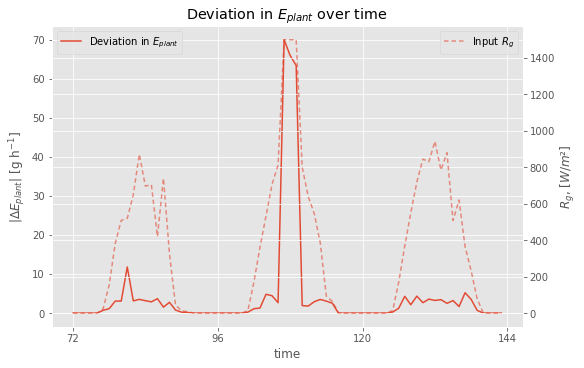

In [11]:
BASELINE = '2012-06-08__width0__0'
EXPERIMENT = '2012-06-08__width3__1500'
OUTPUT = 'output_E'
OUTPUT_SYMBOL = '$E_{plant}$'
OUTPUT_UNIT = "g h$^{-1}$"

START = 24 * 3
STOP = 24 * 6

baseline_out = dataset.get_target(OUTPUT, BASELINE)[START:STOP]
experiment_out = dataset.get_target(OUTPUT, EXPERIMENT)[START:STOP]
experiment_input = dataset.get_target('input_Rg', EXPERIMENT)[START:STOP]

with plt.style.context('ggplot'):
  fig, ax = plt.subplots(1, 1, figsize=(8, 5), constrained_layout=True)
  

  twin = ax.twinx()
  twin.plot(experiment_input, alpha=0.6, dashes=(3,2), linewidth=1.5, label=f'Input {input_symbols["input_Rg"]}')
  twin.set_ylabel(f"{input_symbols['input_Rg']}, [{input_units['input_Rg']}]")
  twin.legend(loc='upper right')

  (np.abs(experiment_out - baseline_out)).plot(ax=ax, label=f'Deviation in {OUTPUT_SYMBOL}')
  ax.set_xticks(np.arange(0, STOP - START + 1, 24))
  ax.set_xticklabels(np.arange(START, STOP + 1, 24))
  ax.set_ylabel(f'|$\Delta${OUTPUT_SYMBOL}| [{OUTPUT_UNIT}]')
  ax.legend(loc='upper left')
  ax.set_title(f'Deviation in {OUTPUT_SYMBOL} over time')

